# Synthèse ML classification

## Préparations des données

In [17]:
import numpy as np
import pandas as pd

def import_data():
    x_train = pd.read_csv(r"Dataset\AG_classif\x_train.csv",index_col=False)
    y_train = pd.read_csv(r"Dataset\AG_classif\y_train.csv",index_col=False)
    x_test = pd.read_csv(r"Dataset\AG_classif\x_test.csv",index_col=False)
    y_test = pd.read_csv(r"Dataset\AG_classif\y_test.csv",index_col=False)

    print("Taille du dataset d'entrainnement :",x_train.shape[0])
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = import_data()

x_train = x_train['0']
y_train = y_train['Class Index']
x_test = x_test['0']
y_test = y_test['Class Index']


Taille du dataset d'entrainnement : 102080


## Préparation des modèles

### Modèle 1 (TF-IDF & MNB)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Create Pipeline
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

# Set parameters to search
parameters_1 = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],               # unigrams ou unigrams + bigrams
    'tfidf__min_df': [1, 2, 3],                           # ignorer les termes trop rares
    'tfidf__max_df': [0.85, 0.95],                        # ignorer les termes trop fréquents
    'tfidf__use_idf': [True, False],                      # tester avec ou sans le facteur IDF
    'tfidf__smooth_idf': [True, False],                   # tester le lissage IDF
    'tfidf__sublinear_tf': [True, False],                 # logarithmiser le comptage
    'nb__alpha': [0.01, 0.1, 0.5, 1.0],
}

def create_pipeline(pipeline,parameters,dfx_train,dfy_train):
    model = HalvingGridSearchCV(
    pipeline,
    parameters,
    cv=3,
    factor=2,
    scoring='accuracy',
    error_score='raise',
    n_jobs=-1,
    verbose=1,
)
    try:
        model.fit(dfx_train, dfy_train)
        print("Best parameters found: ", model.best_params_)
        print("Best score: ", model.best_score_)
    except Exception as e:
        print("An error occurred: ", e)
    
    return model


model_1 = create_pipeline(pipeline_1,parameters_1,x_train,y_train)

n_iterations: 9
n_required_iterations: 9
n_possible_iterations: 9
min_resources_: 398
max_resources_: 102080
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 384
n_resources: 398
Fitting 3 folds for each of 384 candidates, totalling 1152 fits
----------
iter: 1
n_candidates: 192
n_resources: 796
Fitting 3 folds for each of 192 candidates, totalling 576 fits
----------
iter: 2
n_candidates: 96
n_resources: 1592
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 3
n_candidates: 48
n_resources: 3184
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 4
n_candidates: 24
n_resources: 6368
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 5
n_candidates: 12
n_resources: 12736
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 6
n_candidates: 6
n_resources: 25472
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 7
n_candidates: 3
n_re

### Modèle 2 (TF-IDF & SVM)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convertit les textes en vecteurs
    ('classifier', LinearSVC())
])

parameters_2 = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],               # unigrams ou unigrams + bigrams
    'tfidf__min_df': [1, 2, 3],                           # ignorer les termes trop rares
    'tfidf__max_df': [0.85, 0.95],                        # ignorer les termes trop fréquents
    'tfidf__use_idf': [True, False],                      # tester avec ou sans le facteur IDF
    'tfidf__smooth_idf': [True, False],                   # tester le lissage IDF
    'tfidf__sublinear_tf': [True, False],  
    'classifier__C': np.linspace(0.1, 3, 5),
}

model_2 = create_pipeline(pipeline_2,parameters_2,x_train,y_train)

n_iterations: 9
n_required_iterations: 9
n_possible_iterations: 9
min_resources_: 398
max_resources_: 102080
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 480
n_resources: 398
Fitting 3 folds for each of 480 candidates, totalling 1440 fits
----------
iter: 1
n_candidates: 240
n_resources: 796
Fitting 3 folds for each of 240 candidates, totalling 720 fits
----------
iter: 2
n_candidates: 120
n_resources: 1592
Fitting 3 folds for each of 120 candidates, totalling 360 fits
----------
iter: 3
n_candidates: 60
n_resources: 3184
Fitting 3 folds for each of 60 candidates, totalling 180 fits
----------
iter: 4
n_candidates: 30
n_resources: 6368
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------
iter: 5
n_candidates: 15
n_resources: 12736
Fitting 3 folds for each of 15 candidates, totalling 45 fits
----------
iter: 6
n_candidates: 8
n_resources: 25472
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 7
n_candidates: 4
n_

### Modèle 3 (Word embedding & SVM)

#### Initialisation du Word embedding et vectorisation des données

In [20]:
from gensim.models import Word2Vec

vector_size = 300
window = 5
workers = 4

def create_W2V (df):
    W2V_model = Word2Vec(sentences=[doc.split() for doc in df], vector_size=vector_size, window=window, min_count=1, workers=workers)
    return W2V_model

def document_vector(df,model):
    docs=[doc.split() for doc in df]
    doc_embeddings = []
    for doc in docs:
        vectors = [model.wv[word] for word in doc if word in model.wv]
        if vectors:
            doc_embeddings.append(np.mean(vectors, axis=0))
        else:
            doc_embeddings.append(np.zeros(model.vector_size))
    
    return np.array(doc_embeddings)

model_W2V = create_W2V(x_train)
x_train_emb = document_vector(x_train,model_W2V )
x_test_emb = document_vector(x_test,model_W2V )



In [21]:
x_train_emb.shape, x_test_emb.shape

((102080, 300), (25520, 300))

#### Création du modèle

In [22]:
from sklearn.svm import LinearSVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

parameters = {
    'C': np.linspace(0.1, 1, 100)
}

def create_modelSVM(dfx_train, dfy_train):
    model = LinearSVC()
    grid_search = HalvingGridSearchCV(
    model,
    parameters,
    cv=3,
    factor=2,
    scoring='accuracy',
    error_score='raise',
    n_jobs=-1,
    verbose=1,
    )
    try:
        grid_search.fit(dfx_train, dfy_train)
        print("Best parameters found: ", grid_search.best_params_)
        print("Best score: ", grid_search.best_score_)
    except Exception as e:
        print("An error occurred: ", e)
    
    return grid_search

model_3 = create_modelSVM(x_train_emb,y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 1595
max_resources_: 102080
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 100
n_resources: 1595
Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 50
n_resources: 3190
Fitting 3 folds for each of 50 candidates, totalling 150 fits
----------
iter: 2
n_candidates: 25
n_resources: 6380
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 13
n_resources: 12760
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 4
n_candidates: 7
n_resources: 25520
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 5
n_candidates: 4
n_resources: 51040
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 6
n_candidates: 2
n_resources: 102080
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters found:  {'C': 0.32727272727

Justifier pourquoi j'ai pas inclut l'embedding dans le pipeline

## Comparaison des modèles


===== Évaluation de TF-IDF & MNB =====
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': False}
Best cross-validation score: 0.8823
Test accuracy: 0.8863
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.88      0.88      6283
           2       0.94      0.96      0.95      6466
           3       0.85      0.86      0.85      6370
           4       0.87      0.85      0.86      6401

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520



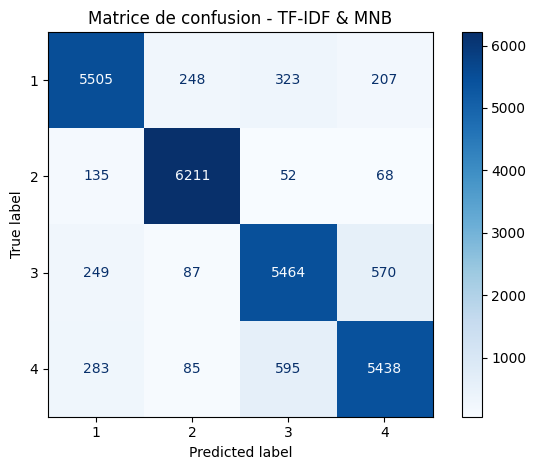


===== Évaluation de TF-IDF & SVM =====
Best parameters: {'classifier__C': 0.825, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best cross-validation score: 0.8864
Test accuracy: 0.8897
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.87      0.89      6283
           2       0.93      0.97      0.95      6466
           3       0.86      0.86      0.86      6370
           4       0.86      0.86      0.86      6401

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520



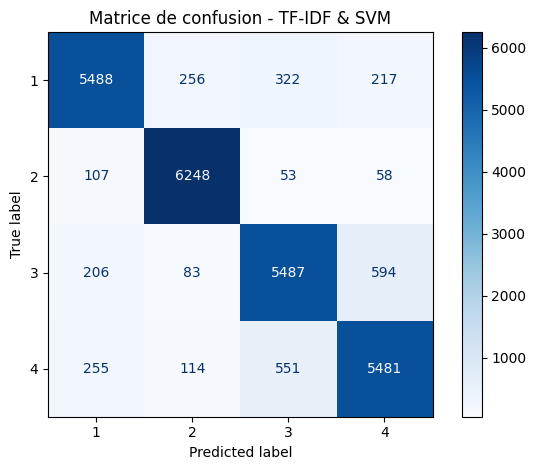


===== Évaluation de Word embedding & SVM =====
Best parameters: {'C': 0.32727272727272727}
Best cross-validation score: 0.8481
Test accuracy: 0.8471
Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.84      0.85      6283
           2       0.90      0.94      0.92      6466
           3       0.81      0.81      0.81      6370
           4       0.81      0.80      0.81      6401

    accuracy                           0.85     25520
   macro avg       0.85      0.85      0.85     25520
weighted avg       0.85      0.85      0.85     25520



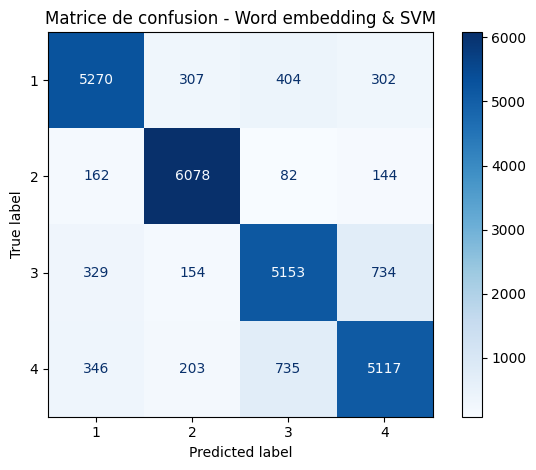

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Liste des modèles à évaluer
model_list = [
    ("TF-IDF & MNB", model_1, x_test, y_test),
    ("TF-IDF & SVM", model_2, x_test, y_test),
    ("Word embedding & SVM", model_3, x_test_emb, y_test),
]

def evaluate(models):
    for name, model, x_test, y_test in models:
        print(f"\n===== Évaluation de {name} =====")
        
        # Affichage des meilleurs paramètres et du score si disponibles
        if hasattr(model, "best_params_"):
            print("Best parameters:", model.best_params_)
        if hasattr(model, "best_score_"):
            print("Best cross-validation score:", f"{model.best_score_:.4f}")

        # Évaluation sur le jeu de test
        try:
            test_score = model.score(x_test, y_test)
            print(f"Test accuracy: {test_score:.4f}")
            
            y_pred = model.predict(x_test)

            print("Classification Report:")
            print(classification_report(y_test, y_pred))

            # Affichage de la matrice de confusion
            cm = confusion_matrix(y_test, y_pred)
            labels = model.classes_ if hasattr(model, "classes_") else sorted(set(y_test))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f"Matrice de confusion - {name}")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Une erreur est survenue pendant l’évaluation de {name} : {e}")

    return None

# Appel
evaluate(model_list)


## Sauvegarder les modèles

In [24]:
import joblib
joblib.dump(model_1, r'Model\Classification\Général\model1.pkl')
joblib.dump(model_2, r'Model\Classification\Général\model2.pkl')
joblib.dump(model_3, r'Model\Classification\Général\model3.pkl')

['Model\\Classification\\Général\\model3.pkl']